Loading UNSEEN test data from: ../results/features_test_set.csv
Test data loaded successfully!
Shape of the test dataset: (915, 11)

Value counts for test set classes:
gcs_class
GCS 3 (Word Salad)          151
GCS 4/5 (Coherent)          109
GCS 2 (Incomprehensible)     28
Name: count, dtype: int64

==================== FINAL PERFORMANCE ON UNSEEN TEST SET ====================

Classification Report (Test Set):
              precision    recall  f1-score   support

       GCS 2       0.25      1.00      0.39        28
       GCS 3       0.64      0.18      0.28       151
     GCS 4/5       0.50      0.60      0.54       109

   micro avg       0.42      0.42      0.42       288
   macro avg       0.46      0.59      0.41       288
weighted avg       0.55      0.42      0.39       288


Overall Accuracy (Test Set): 41.67%

Confusion Matrix (Test Set):


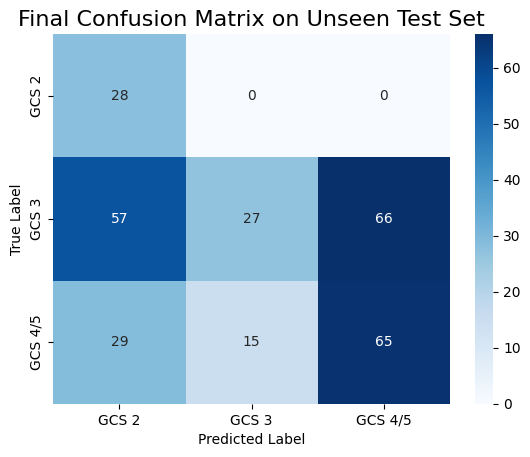

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

project_root = ".." 
sys.path.append(os.path.join(project_root, 'src'))

# Import the necessary functions
from classifier import normalize_feature

# --- Step 1: Load the unseen Test Data ---
results_dir = os.path.join(project_root, "results")
test_csv_path = os.path.join(results_dir, "features_test_set.csv")

print(f"Loading UNSEEN test data from: {test_csv_path}")
try:
    df_test = pd.read_csv(test_csv_path)
    print("Test data loaded successfully!")
    print(f"Shape of the test dataset: {df_test.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at {test_csv_path}")
    print("Please make sure the 'run_batch_processing.py' script has been run successfully for the test set.")

# --- Step 2: Prepare the Test Data ---
# Create the 'gcs_class' column and filter out noisy data 
def get_gcs_class(category):
    if category == 'gcs_2':
        return 'GCS 2 (Incomprehensible)'
    elif category == 'gcs_3':
        return 'GCS 3 (Word Salad)'
    elif category == 'gcs_45_clean':
        return 'GCS 4/5 (Coherent)'
    else:
        return 'Other (Noisy)'

if 'df_test' in locals():
    df_test['gcs_class'] = df_test['category'].apply(get_gcs_class)
    df_test_clean = df_test[df_test['gcs_class'] != 'Other (Noisy)'].copy()
    print("\nValue counts for test set classes:")
    print(df_test_clean['gcs_class'].value_counts())

    # --- Step 3: Define the final Model from Validation ---
    
    # Normalization Constants (same as in validation)
    CONFIDENCE_MIN = -2.0
    CONFIDENCE_MAX = -0.1
    PERPLEXITY_MIN = 10.0
    PERPLEXITY_MAX = 10000.0
    
    # The parameters of "Certainty-First" Decision Tree (Iteration 9)
    LEXICAL_THRESHOLD_FOR_GCS2 = 0.5   
    CONFIDENCE_THRESHOLD_FOR_GCS2 = 0.45
    PERPLEXITY_THRESHOLD_FOR_GCS45 = 0.75
    CONFIDENCE_THRESHOLD_FOR_GCS45 = 0.55
    
    # The final classifier function
    def classify_gcs_level_rule_based(normalized_features, no_speech_prob, raw_features):
        if no_speech_prob > 0.8: return 1
        
        transcription_text = str(raw_features.get('transcription', ''))
        num_words = len(transcription_text.split())

        if num_words <= 2:
            if normalized_features['norm_confidence'] > 0.6: # Using the value from the successful "smart word count" logic
                return 5
            else:
                return 2

        if normalized_features['norm_lexical'] < LEXICAL_THRESHOLD_FOR_GCS2 or \
           normalized_features['norm_confidence'] < CONFIDENCE_THRESHOLD_FOR_GCS2:
            return 2
            
        if normalized_features['norm_inv_perplexity'] > PERPLEXITY_THRESHOLD_FOR_GCS45 and \
           normalized_features['norm_confidence'] > CONFIDENCE_THRESHOLD_FOR_GCS45:
            return 5
            
        return 3

    # --- Step 4: Apply the Final Classifier to the Test Data ---
    predictions = []
    for index, row in df_test_clean.iterrows():
        norm_conf = normalize_feature(row['avg_logprob'], CONFIDENCE_MIN, CONFIDENCE_MAX)
        norm_lex = np.clip(row['lexical_validity'], 0.0, 1.0)
        norm_inv_ppl = normalize_feature(row['perplexity'], PERPLEXITY_MIN, PERPLEXITY_MAX, invert=True)
        
        normalized_features = {
            'norm_confidence': norm_conf,
            'norm_lexical': norm_lex,
            'norm_inv_perplexity': norm_inv_ppl
        }
        raw_features = {'transcription': row['transcription']}
        no_speech_prob = row.get('whisper_no_speech_prob', 0)
        
        predicted_level = classify_gcs_level_rule_based(normalized_features, no_speech_prob, raw_features)
        predictions.append(predicted_level)

    df_test_clean['predicted_gcs_level'] = predictions

    # --- Step 5: Report the Final, Unbiased Performance ---
    def map_true_class_to_numeric(gcs_class_str):
        if gcs_class_str == 'GCS 2 (Incomprehensible)': return 2
        if gcs_class_str == 'GCS 3 (Word Salad)': return 3
        if gcs_class_str == 'GCS 4/5 (Coherent)': return 5
        return 0

    df_test_clean['true_gcs_level'] = df_test_clean['gcs_class'].apply(map_true_class_to_numeric)
    true_labels = df_test_clean['true_gcs_level']
    predicted_labels = df_test_clean['predicted_gcs_level']

    report_labels = [2, 3, 5]
    report_target_names = ['GCS 2', 'GCS 3', 'GCS 4/5']

    print("\n" + "="*20 + " FINAL PERFORMANCE ON UNSEEN TEST SET " + "="*20)
    print("\nClassification Report (Test Set):")
    print(classification_report(true_labels, predicted_labels, 
                                labels=report_labels, 
                                target_names=report_target_names,
                                zero_division=0))

    print(f"\nOverall Accuracy (Test Set): {accuracy_score(true_labels, predicted_labels):.2%}")

    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(true_labels, predicted_labels, labels=[2, 3, 5])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=report_target_names,
                yticklabels=report_target_names)
    plt.title('Final Confusion Matrix on Unseen Test Set', fontsize=16)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()